In [2]:
import pandas as pd

In [3]:
df_201910 = pd.read_csv('../data/201910-capitalbikeshare-tripdata.csv')
df_202010 = pd.read_csv('../data/202010-capitalbikeshare-tripdata.csv')
df_202110 = pd.read_csv('../data/202110-capitalbikeshare-tripdata.csv')
df_202210 = pd.read_csv('../data/202210-capitalbikeshare-tripdata.csv')

In [4]:
print(df_201910.columns)
print(df_202010.columns)

Index(['Duration', 'Start date', 'End date', 'Start station number',
       'Start station', 'End station number', 'End station', 'Bike number',
       'Member type'],
      dtype='object')
Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


In [5]:
df_201910.rename(columns={
    'Duration':'Duration', 
    'Start date':'started_at', 
    'End date':'ended_at',
    'Start station number':'start_station_id',
    'Start station':'start_station_name', 
    'End station number':'end_station_id', 
    'End station':'end_station_name', 
    'Bike number':'Bike number',
    'Member type':'member_casual'
}, inplace=True)

In [6]:
df_201910 = df_201910.dropna()
df_202010 = df_202010.dropna()
df_202110 = df_202110.dropna()
df_202210 = df_202210.dropna()

In [7]:
# number of rows for entire dataset
len(df_201910)+len(df_202010)+len(df_202110)+len(df_202210)

1158641

In [8]:
# merge df
merge_df = pd.concat([df_201910, df_202010,df_202110,df_202210], ignore_index=True, sort=False)

In [121]:
# Manipulate and clean columns
merge_df['ended_at'] = pd.to_datetime(merge_df['ended_at'])
merge_df['started_at'] = pd.to_datetime(merge_df['started_at'])
merge_df['Duration'] = merge_df['ended_at']-merge_df['started_at']
merge_df['Duration'] = merge_df['Duration'].dt.total_seconds()
merge_df['Year'] = merge_df['started_at'].dt.year
merge_df['Month'] = merge_df['started_at'].dt.month
merge_df['Dat'] = merge_df['started_at'].dt.day
merge_df.member_casual = merge_df.member_casual.str.lower()

In [122]:
# starting IDs that can't be matched
start_empty = merge_df[merge_df.start_lat.isna() | merge_df.start_lng.isna()]
start_not_empty = merge_df[merge_df.start_lat.notna() & merge_df.start_lng.notna()]

start_a = set(start_empty.start_station_id)
start_b = set(start_not_empty.start_station_id)

# starting IDs that can't be matched
end_empty = merge_df[merge_df.end_lat.isna() | merge_df.end_lng.isna()]
end_not_empty = merge_df[merge_df.end_lat.notna() & merge_df.end_lng.notna()]

end_a = set(end_empty.start_station_id)
end_b = set(end_not_empty.start_station_id)

merge_df = merge_df[~merge_df['start_station_id'].isin(list((start_a-start_b) | (end_a-end_b)))]

In [147]:
# fill in station latitude longitude missing values for 2019

station_index = merge_df[merge_df.start_lat.notna()].groupby('start_station_id')[['start_lat','start_lng']].first().reset_index()

merge_df['start_lat'] = merge_df['start_lat'].fillna(merge_df['start_station_id'].map(station_index.set_index('start_station_id')['start_lat']))
merge_df['start_lng'] = merge_df['start_lng'].fillna(merge_df['start_station_id'].map(station_index.set_index('start_station_id')['start_lng']))
merge_df['end_lat'] = merge_df['end_lat'].fillna(merge_df['end_station_id'].map(station_index.set_index('start_station_id')['start_lat']))
merge_df['end_lng'] = merge_df['end_lng'].fillna(merge_df['end_station_id'].map(station_index.set_index('start_station_id')['start_lng']))


C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_12600\530359626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df['start_lat'] = merge_df['start_lat'].fillna(merge_df['start_station_id'].map(station_index.set_index('start_station_id')['start_lat']))
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_12600\530359626.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df['start_lng'] = merge_df['start_lng'].fillna(merge_df['start_station_id'].map(station_index.set_index('start_station_id')['st

In [160]:
merge_df.groupby(['Year','Month']).agg({'Duration':'mean','start_station_id':'count'})

,,Duration,start_station_id
Year,Month,,
2019,10,988.984889,337513
2020,10,2275.411350,202426
2021,10,1300.395713,303533
2022,10,1201.917510,315130


In [166]:
Q1 = merge_df['Duration'].quantile(0.25)
Q3 = merge_df['Duration'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outliers = merge_df[(merge_df['Duration'] >= lower_bound) & (merge_df['Duration'] <= upper_bound)]
df_outliers = merge_df[(merge_df['Duration'] < lower_bound) | (merge_df['Duration'] > upper_bound)]

In [173]:
import statistics

statistics.mean(df_outliers['Duration']/60)

Q1 = df_outliers['Duration'].quantile(0.25)
Q3 = df_outliers['Duration'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(lower_bound,upper_bound)

-1259.125 9895.875


In [161]:
df_no_outliers.groupby(['Year','Month']).agg({'Duration':'mean','start_station_id':'count'})

,,Duration,start_station_id
Year,Month,,
2019,10,751.331786,321469
2020,10,835.712959,181699
2021,10,810.192486,275807
2022,10,766.964842,290457


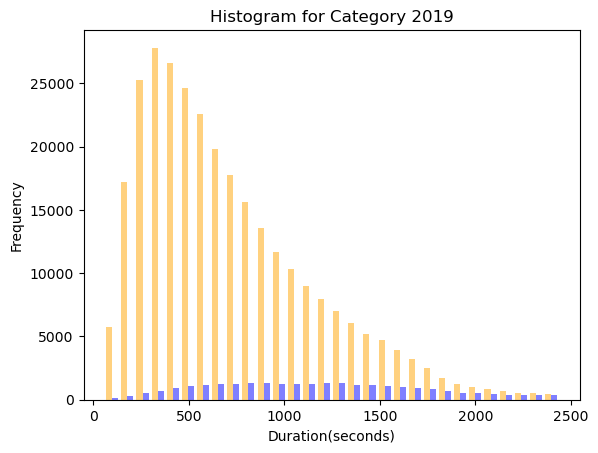

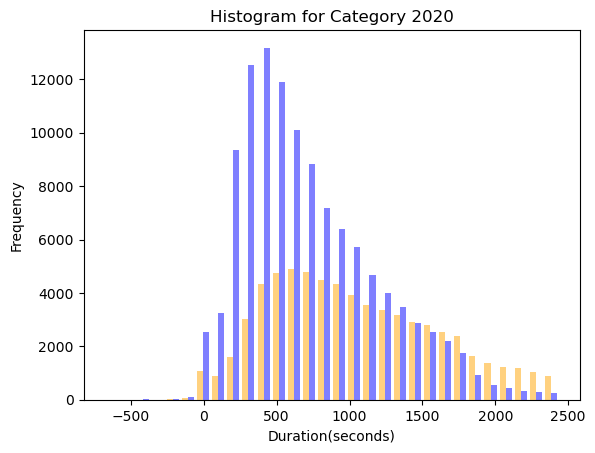

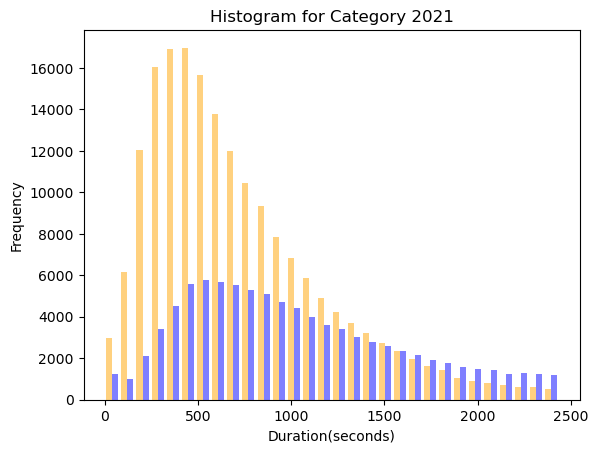

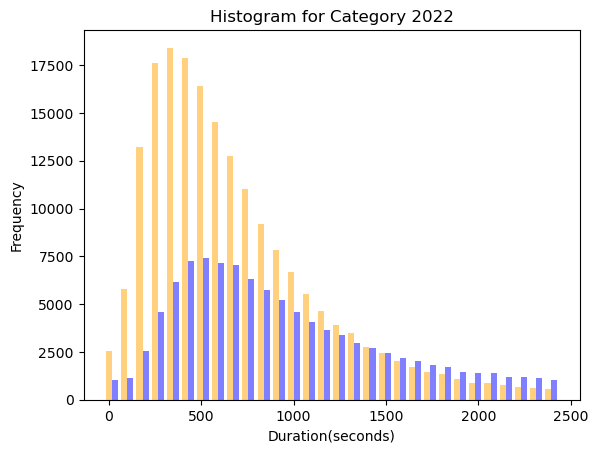

In [187]:
import matplotlib.pyplot as plt

colors = {'member': 'orange', 'casual': 'blue'}

for category in merge_df.Year.unique():
    plt.figure()  # Create a new figure for each category
    subset_df = df_no_outliers[df_no_outliers['Year'] == category]
    # plt.hist(subset_df['Duration'], bins=5, color='skyblue', edgecolor='black')

    plt.hist([subset_df[subset_df['member_casual'] == cat]['Duration'] for cat in subset_df['member_casual'].unique()],
         bins=30, alpha=0.5, color=[colors[cat] for cat in colors.keys()], label=colors.keys())
    plt.xlabel('Duration(seconds)')
    plt.ylabel('Frequency')
    plt.title(f'Histogram for Category {category}')

In [190]:
id_count = merge_df.groupby(['Year','start_station_id']).size().reset_index(name='Count')

map_df = pd.merge(id_count, station_index, on='start_station_id')
map_df.head()

,Year,start_station_id,Count,start_lat,start_lng
0,2019,31000.0,172,38.858971,-77.05323
1,2020,31000.0,121,38.858971,-77.05323
2,2021,31000.0,218,38.858971,-77.05323
3,2022,31000.0,284,38.858971,-77.05323
4,2019,31001.0,185,38.857250,-77.05332


In [201]:
import folium
from IPython.display import display

for i in list(map_df.Year.unique()):
    subset_df = map_df[map_df['Year'] == i]

    latitudes = list(subset_df['start_lat'])
    longitudes = list(subset_df['start_lng'])
    size = list(subset_df['Count'])

    # Create a folium map centered at the average location
    map_center = [sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)]
    my_map = folium.Map(location=map_center, zoom_start=12.5)

    # Add markers for latitude and longitude points
    for lat, lon, size in zip(latitudes, longitudes, size):
        folium.CircleMarker(location=[lat, lon], radius=size / 300, popup=f"Lat: {lat}, Lon: {lon}", fill=True).add_to(my_map)

    # Display the map
    display(my_map)
